In [15]:
# define the RBM

import numpy as np

class RBM:
    def __init__(self, num_visible, num_hidden):
        # Initialize the number of visible and hidden units
        self.num_visible = num_visible
        self.num_hidden = num_hidden

        # Initialize weights with normally distributed random values, and biases with zeros
        self.weights = np.random.normal(scale=0.1, size=(num_visible, num_hidden))
        self.visible_bias = np.zeros(num_visible)
        self.hidden_bias = np.zeros(num_hidden)

    def _sigmoid(self, x):
        # Sigmoid activation function used for calculating probabilities
        return 1 / (1 + np.exp(-x))

    def train(self, data, num_epochs=100, initial_learning_rate=0.1, decay_rate=0.1):
        num_samples = data.shape[0]  # Number of training samples
        losses = []  # List to keep track of loss per epoch

        for epoch in range(num_epochs):
            # Decay learning rate as training progresses
            learning_rate = initial_learning_rate * np.exp(-decay_rate * epoch)

            # Positive phase - calculate the probabilities of the hidden units given the visible units
            hidden_prob = self._sigmoid(np.dot(data, self.weights) + self.hidden_bias)
            hidden_state = self._sample(hidden_prob)  # Sample from the calculated probabilities

            # Negative phase - reconstruct the visible units from the sampled hidden states
            visible_recon_prob = self._sigmoid(np.dot(hidden_state, self.weights.T) + self.visible_bias)
            visible_recon_state = self._sample(visible_recon_prob)  # Sample from the reconstructed probabilities
            hidden_recon_prob = self._sigmoid(np.dot(visible_recon_state, self.weights) + self.hidden_bias)

            # Calculate reconstruction error
            loss = np.mean((data - visible_recon_state) ** 2)
            losses.append(loss)  # Append loss for the epoch to the list

            # Update weights using Contrastive Divergence (CD)
            positive_associations = np.dot(data.T, hidden_prob)  # Positive phase associations
            negative_associations = np.dot(visible_recon_state.T, hidden_recon_prob)  # Negative phase associations
            self.weights += learning_rate * (positive_associations - negative_associations) / num_samples
            self.visible_bias += learning_rate * (np.sum(data - visible_recon_state, axis=0)) / num_samples
            self.hidden_bias += learning_rate * (np.sum(hidden_prob - hidden_recon_prob, axis=0)) / num_samples

        return losses

    def _sample(self, prob):
        # Sample binary states based on probabilities (stochastic binary units)
        return (np.random.random(size=prob.shape) < prob).astype(np.float32)
    
    def generate_sequence(self, initial_state, num_steps):
        # Generate a sequence of visible states by iteratively passing through hidden and visible layers
        state = initial_state
        sequence = []

        for step in range(num_steps):
            # Compute hidden units given the visible state
            hidden_prob = self._sigmoid(np.dot(state, self.weights) + self.hidden_bias)
            hidden_state = self._sample(hidden_prob)

            # Compute visible units given the hidden state
            visible_prob = self._sigmoid(np.dot(hidden_state, self.weights.T) + self.visible_bias)
            state = self._sample(visible_prob)

            sequence.append(state)

        return np.array(sequence)
    
    def free_energy(self, v):

    # Compute the free energy of the visible units.
    # 'v' is the visible units vector.
    
        hidden_term = np.sum(np.log(1 + np.exp(self.hidden_bias + np.dot(v, self.weights))), axis=1)
        return -np.dot(v, self.visible_bias) - hidden_term
    
    def to_spin(self, prob):
        # Convert probabilities to binary spin states (-1 or 1)
        return np.where(np.random.random(size=prob.shape) < prob, 1, -1)

    def _sample_hidden(self, visible):
        # Compute the hidden states given the visible states
        hidden_activations = np.dot(visible, self.weights) + self.hidden_bias
        hidden_prob = self._sigmoid(hidden_activations)
        return self.to_spin(hidden_prob)

    def _sample_visible(self, hidden):
        # Compute the visible states given the hidden states
        visible_activations = np.dot(hidden, self.weights.T) + self.visible_bias
        visible_prob = self._sigmoid(visible_activations)
        return self.to_spin(visible_prob)


In [16]:
# import trained RBM (its trained state information)

import pickle

with open('trained_rbm.pkl', 'rb') as file:
    trained_rbm = pickle.load(file)

In [18]:
# import 25 temp dataset

configs_25_temps = np.load('rbm_data_25_temps.npy')

In [25]:
# need shape (50000,100)

print(configs_25_temps.shape) # This should print (50000, 100)
print(len(trained_rbm.visible_bias)) # This should print 100


(50000, 100)
100


In [26]:
# reshape as required

configs_25_temps = configs_25_temps.reshape((50000, 100))


In [27]:
def softmax(x):
    e_x = np.exp(x - np.max(x))  # subtract max(x) for numerical stability
    return e_x / e_x.sum(axis=0)  # along the appropriate axis

### Ensure my RBM is trained with 100 visible units since flatting the 10x10 lattice gives configuration sizes of 100

In [34]:
# calculate free energies and softmax probs
free_energies = trained_rbm.free_energy(configs_25_temps)
softmax_probs = softmax(-free_energies)


In [35]:
# Reshape the softmax probabilities to match the original data structure
softmax_probs = softmax_probs.reshape((25, 2000))

# Calculate average softmax probabilities for each temperature
avg_softmax_probs = softmax_probs.mean(axis=1)


In [36]:
temperatures = [0.000001, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 
                3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0]

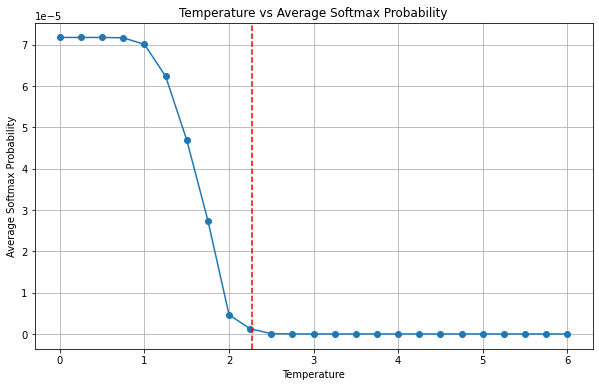

In [39]:
import matplotlib.pyplot as plt

# let's assume temp_list is your list of temperatures and softmax_prob_list is your list of softmax probabilities
Tc = 2 / np.log(1 + np.sqrt(2))  # critical temperature

plt.figure(figsize=(10,6))
plt.plot(temperatures, avg_softmax_probs, 'o-')
plt.axvline(x=Tc, color='r', linestyle='--')  # add vertical line at Tc
plt.xlabel('Temperature')
plt.ylabel('Average Softmax Probability')
plt.title('Temperature vs Average Softmax Probability')
plt.grid(True)
plt.show()




## note: this looks like $T_0=0$ flows in previous results